In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

print('Imports Done')

Imports Done


Using chessboard images to calibrate the camera

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)

        # this step to refine image points was taken from:
        #Refernce:  http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img', img)
        cv2.waitKey(500)

cv2.destroyAllWindows()
    

This is the test for undistortion!


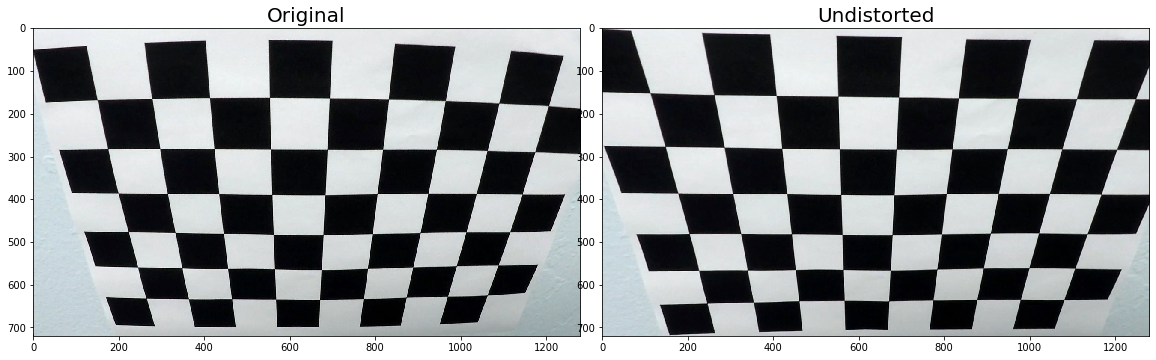

In [3]:
# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration2.jpg')
img_size = (img.shape[1], img.shape[0])

# Camera calibration using given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .4, wspace=.04)
ax1.imshow(img)
ax1.set_title('Original', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted', fontsize=20)
print('This is the test for undistortion!')

Your image is loaded


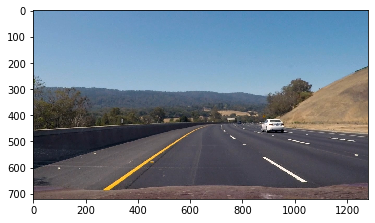

In [4]:
# Choose an image from which to build and demonstrate each step of the pipeline
example_img = cv2.imread('test_images/test3.jpg')
example_img = cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB)
plt.imshow(example_img)
print('Your image is loaded')

your image is distorted
BAzinga! This is your undistorted road image


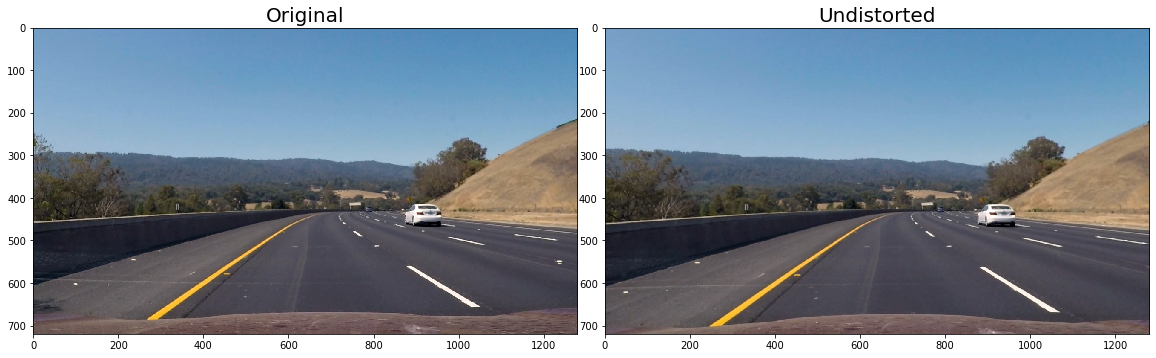

In [5]:
#Undistort this road image (using calibration elememts from chessboard steps above) and then visualize it

def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
print('your image is distorted')

example_img_undistort = undistort(example_img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .5, wspace=.05)
ax1.imshow(example_img)
ax1.set_title('Original', fontsize=20)
ax2.imshow(example_img_undistort)
ax2.set_title('Undistorted', fontsize=20)

print('BAzinga! This is your undistorted road image')

Next is perspective tranform. I have problems in getting destinationa nd source points. Need better and robust algorithms that can detect the 4 points themselves. But for my project, I have taken points manually.  

In [6]:
#function for transform (arguments --> image, sourcepoints and destination points)
def unwarp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv
print('This is your perspective transform function')

This is your perspective transform function


(720, 1280, 3)
Image after perspective transform


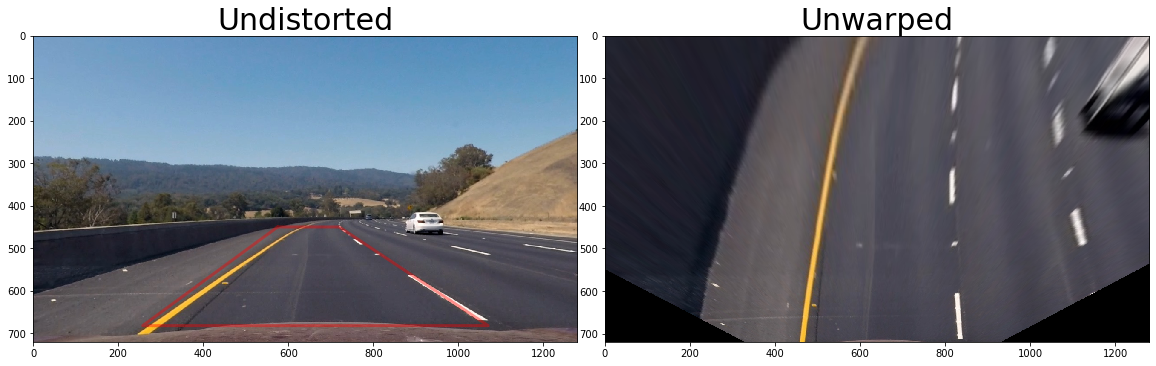

In [7]:
#Applying above function on test image and visualize it.

#The points need to be sorted “clockwise”, starting from top-left. Have to check??
h,w = example_img_undistort.shape[:2]
print(example_img_undistort.shape)

# define source and destination points for transform
src = np.float32([(575,450),(720,450),(258,682),(1070,682)])
dst = np.float32([(450,0),(w-450,0),(450,h),(w-450,h)])

#src = np.float32([(575,450),(720,450),(1070,682),(258,682)])
#dst = np.float32([(450,0),(w-450,0),(w-450,h),(450,h)])


src_m = np.float32([[581, 478],[720, 478],[1070, 675],[260, 675]])
dst_m = np.float32([[384, 0],[896, 0],[896, 720],[384, 720]])

example_img_unwarp, M, Minv = unwarp(example_img_undistort, src, dst)

example_img_unwarp_m, M, Minv = unwarp(example_img_undistort, src_m, dst_m)

# Visualization
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .5, wspace=.05)
ax1.imshow(example_img_undistort)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted', fontsize=30)
ax2.imshow(example_img_unwarp)
ax2.set_title('Unwarped', fontsize=30)

# Visualization
##f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
##f.subplots_adjust(hspace = .5, wspace=.05)
##ax1.imshow(example_img_undistort)
##x = [src_m[0][0],src_m[2][0],src_m[3][0],src_m[1][0],src[0][0]]
##y = [src_m[0][1],src_m[2][1],src_m[3][1],src_m[1][1],src_m[0][1]]
##ax1.plot(x, y, color='red', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
##ax1.set_ylim([h,0])
##ax1.set_xlim([0,w])
##ax1.set_title('Undistorted', fontsize=30)
##ax2.imshow(example_img_unwarp_m)
##ax2.set_title('Unwarped', fontsize=30)

print('Image after perspective transform')


In [8]:
#Applying and visualizing color gradients

# Visualize multiple color space channels
example_img_unwarp_R = example_img_unwarp[:,:,0]
example_img_unwarp_G = example_img_unwarp[:,:,1]
example_img_unwarp_B = example_img_unwarp[:,:,2]
example_img_unwarp_HSV = cv2.cvtColor(example_img_unwarp, cv2.COLOR_RGB2HSV)
example_img_unwarp_H = example_img_unwarp_HSV[:,:,0]
example_img_unwarp_S = example_img_unwarp_HSV[:,:,1]
example_img_unwarp_V = example_img_unwarp_HSV[:,:,2]
example_img_unwarp_LAB = cv2.cvtColor(example_img_unwarp, cv2.COLOR_RGB2Lab)
example_img_unwarp_L = example_img_unwarp_LAB[:,:,0]
example_img_unwarp_A = example_img_unwarp_LAB[:,:,1]
example_img_unwarp_B2 = example_img_unwarp_LAB[:,:,2]


Visualizing different color channels


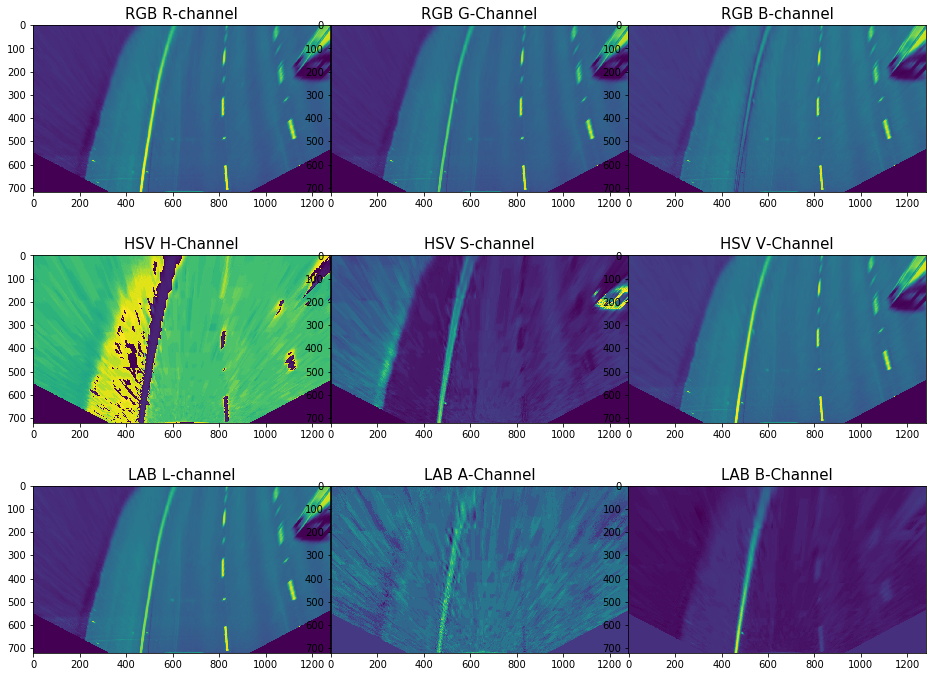

In [9]:
fig, axs = plt.subplots(3,3, figsize=(16, 12))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
axs[0].imshow(example_img_unwarp_R)
axs[0].set_title('RGB R-channel', fontsize=15)
axs[1].imshow(example_img_unwarp_G)
axs[1].set_title('RGB G-Channel', fontsize=15)
axs[2].imshow(example_img_unwarp_B)
axs[2].set_title('RGB B-channel', fontsize=15)
axs[3].imshow(example_img_unwarp_H)
axs[3].set_title('HSV H-Channel', fontsize=15)
axs[4].imshow(example_img_unwarp_S)
axs[4].set_title('HSV S-channel', fontsize=15)
axs[5].imshow(example_img_unwarp_V)
axs[5].set_title('HSV V-Channel', fontsize=15)
axs[6].imshow(example_img_unwarp_L)
axs[6].set_title('LAB L-channel', fontsize=15)
axs[7].imshow(example_img_unwarp_A)
axs[7].set_title('LAB A-Channel', fontsize=15)
axs[8].imshow(example_img_unwarp_B2)
axs[8].set_title('LAB B-Channel', fontsize=15)
print('Visualizing different color channels')

Text(0.5, 1.0, 'LAB B-Channel_gray')

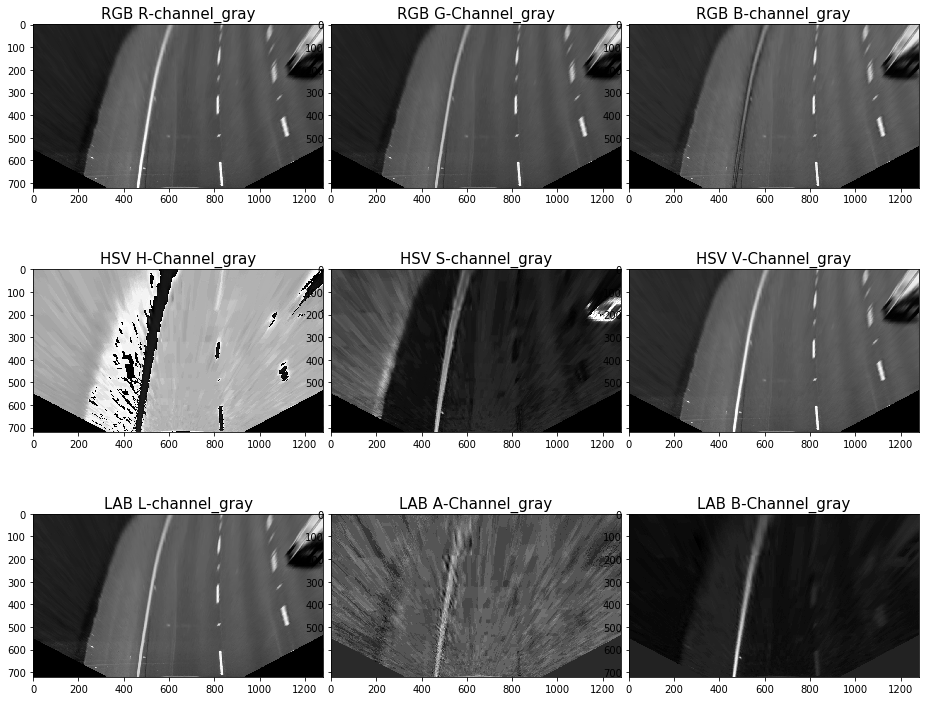

In [10]:
fig, axs = plt.subplots(3,3, figsize=(16, 12))
fig.subplots_adjust(hspace = .5, wspace=.002)
axs = axs.ravel()
axs[0].imshow(example_img_unwarp_R, cmap='gray')
axs[0].set_title('RGB R-channel_gray', fontsize=15)
axs[1].imshow(example_img_unwarp_G, cmap='gray')
axs[1].set_title('RGB G-Channel_gray', fontsize=15)
axs[2].imshow(example_img_unwarp_B, cmap='gray')
axs[2].set_title('RGB B-channel_gray', fontsize=15)
axs[3].imshow(example_img_unwarp_H, cmap='gray')
axs[3].set_title('HSV H-Channel_gray', fontsize=15)
axs[4].imshow(example_img_unwarp_S, cmap='gray')
axs[4].set_title('HSV S-channel_gray', fontsize=15)
axs[5].imshow(example_img_unwarp_V, cmap='gray')
axs[5].set_title('HSV V-Channel_gray', fontsize=15)
axs[6].imshow(example_img_unwarp_L, cmap='gray')
axs[6].set_title('LAB L-channel_gray', fontsize=15)
axs[7].imshow(example_img_unwarp_A, cmap='gray')
axs[7].set_title('LAB A-Channel_gray', fontsize=15)
axs[8].imshow(example_img_unwarp_B2, cmap='gray')
axs[8].set_title('LAB B-Channel_gray', fontsize=15)



# Gradient Threshold
Here we are going to develop three function. 
(1)--> (Sobel) Gradient x and then apply threshold
(2)--> Magnitude of the gradient and then apply threshold
(3)--> Direction of gradient and then apply threshold

In [11]:
# Define a function that applies Sobel x or y, We know that
#gradient orientation works best in x diresction therefore we will apply in x direction.
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255):
    # Apply the following steps to img
    # 1) Convert to grayscale === or LAB L channel
    gray = (cv2.cvtColor(img, cv2.COLOR_RGB2Lab))[:,:,0]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y')
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary # Remove this line
    return binary_output

In [12]:
#Finding the threshold using GUI and then visualizing image after the
#application of threshold

def update(min_thresh, max_thresh):
    example_img_sobelAbs = abs_sobel_thresh(example_img_unwarp, 'x', min_thresh, max_thresh)
    # Visualize sobel absolute threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .5, wspace=.05)
    ax1.imshow(example_img_unwarp)
    ax1.set_title('Unwarped Image', fontsize=20)
    ax2.imshow(example_img_sobelAbs, cmap='gray')
    ax2.set_title('Sobel Absolute', fontsize=20)

    
print("Slide the button and adjust the min_thresh and max_thresh for best threshold values")

interact(update, 
         min_thresh=(0,255), 
         max_thresh=(0,255))



Slide the button and adjust the min_thresh and max_thresh for best threshold values


interactive(children=(IntSlider(value=127, description='min_thresh', max=255), IntSlider(value=127, descriptio…

<function __main__.update(min_thresh, max_thresh)>

In [13]:
# Define a function that applies magnitude of gradient, 
# then takes an absolute value and applies a threshold.

def mag_thresh(img, sobel_kernel=25, mag_thresh=(25, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(sxbinary) 
    return binary_output


In [14]:
#Finding the threshold using GUI and then visualizing image after the
#application of threshold
def update(kernel_size, min_thresh, max_thresh):
    example_img_sobelMag = mag_thresh(example_img_unwarp, kernel_size, (min_thresh, max_thresh))
    # Visualize sobel magnitude threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .5, wspace=.05)
    ax1.imshow(example_img_unwarp)
    ax1.set_title('Unwarped Image', fontsize=20)
    ax2.imshow(example_img_sobelMag, cmap='gray')
    ax2.set_title('Sobel Magnitude', fontsize=20)

    
print("Slide the button and adjust the min_thresh and max_thresh for best threshold values")

interact(update, kernel_size=(1,31,2), 
                 min_thresh=(0,255), 
                 max_thresh=(0,255))


Slide the button and adjust the min_thresh and max_thresh for best threshold values


interactive(children=(IntSlider(value=15, description='kernel_size', max=31, min=1, step=2), IntSlider(value=1…

<function __main__.update(kernel_size, min_thresh, max_thresh)>

In [15]:
# Define a function that applies direction of gradient
# then takes an absolute value and applies a threshold.
def dir_thresh(img, sobel_kernel=7, thresh=(0, 0.09)):    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output


In [16]:
#Finding the threshold using GUI and then visualizing image after the
#application of threshold
def update(kernel_size, min_thresh, max_thresh):
    example_img_sobelDir = dir_thresh(example_img_unwarp, kernel_size, (min_thresh, max_thresh))
    # Visualize sobel direction threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .5, wspace=.05)
    ax1.imshow(example_img_unwarp)
    ax1.set_title('Unwarped Image', fontsize=20)
    ax2.imshow(example_img_sobelDir, cmap='gray')
    ax2.set_title('Sobel Direction', fontsize=20)

print("Slide the button and adjust the min_thresh and max_thresh for best threshold values")

interact(update, kernel_size=(1,31,2), 
                 min_thresh=(0,np.pi/2,0.01), 
                 max_thresh=(0,np.pi/2,0.01))

Slide the button and adjust the min_thresh and max_thresh for best threshold values


interactive(children=(IntSlider(value=15, description='kernel_size', max=31, min=1, step=2), FloatSlider(value…

<function __main__.update(kernel_size, min_thresh, max_thresh)>

Since we have developed the function for both 
Applying threshold to gradient's magnitude
Applying threshold to gradient's direction

In [17]:
def update(mag_kernel_size, mag_min_thresh, mag_max_thresh, dir_kernel_size, dir_min_thresh, dir_max_thresh):
    example_img_sobelMag2 = mag_thresh(example_img_unwarp, mag_kernel_size, (mag_min_thresh, mag_max_thresh))
    example_img_sobelDir2 = dir_thresh(example_img_unwarp, dir_kernel_size, (dir_min_thresh, dir_max_thresh))
    combined = np.zeros_like(example_img_sobelMag2)
    combined[((example_img_sobelMag2 == 1) & (example_img_sobelDir2 == 1))] = 1
    # Visualize sobel magnitude + direction threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .5, wspace=.05)
    ax1.imshow(example_img_unwarp)
    ax1.set_title('Unwarped Image', fontsize=20)
    ax2.imshow(combined, cmap='gray')
    ax2.set_title('Sobel Magnitude + Direction', fontsize=20)

print('Adjust these thresholds to ge the best image output that clearly detects the lane lines')
interact(update, mag_kernel_size=(1,31,2), 
                 mag_min_thresh=(0,255), 
                 mag_max_thresh=(0,255),
                 dir_kernel_size=(1,31,2), 
                 dir_min_thresh=(0,np.pi/2,0.01), 
                 dir_max_thresh=(0,np.pi/2,0.01))

Adjust these thresholds to ge the best image output that clearly detects the lane lines


interactive(children=(IntSlider(value=15, description='mag_kernel_size', max=31, min=1, step=2), IntSlider(val…

<function __main__.update(mag_kernel_size, mag_min_thresh, mag_max_thresh, dir_kernel_size, dir_min_thresh, dir_max_thresh)>

# Color Threshold
We have created function for the gradient threshold. Now we create function for color threshold. We can create3 function for both HLS and LAB colour Spaces
(1)--> HLS H-channel(hue) 
(2)--> HLS L-channel(lightness)
(3)--> HLS S-channel(saturation)
(4)--> LAB L-channel(L* for the lightness from black (0) to white (100))
(5)--> LAB A-channel(a* from green (−) to red (+))
(6)--> LAB B-channel(b* from blue (−) to yellow (+))
*************but here we will create 4 functions (1)[HLS H-channel] ,(2)[HLS L-channel] ,(3)[HLS S-channel] ,(6)[LAB B-channel]

In [18]:
#HLS
# This function thresholds the H-channel of HLS (Although H-channel is not much useful)
# We are using the exclusive lower bound (>) and inclusive upper (<=)
def hls_hthresh(img, thresh=(125, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(hls[:,:,0])
    binary_output[(hls[:,:,0] > thresh[0]) & (hls[:,:,0] <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

In [19]:
#HLS
#Visualizing the H thresholds
def update(min_thresh, max_thresh):
    example_img_HThresh = hls_hthresh(example_img_unwarp, (min_thresh, max_thresh))
    # Visualize hls h-channel threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .5, wspace=.05)
    ax1.imshow(example_img_unwarp)
    ax1.set_title('Unwarped', fontsize=20)
    ax2.imshow(example_img_HThresh, cmap='gray')
    ax2.set_title('HLS H-Channel', fontsize=20)

interact(update,
         min_thresh=(0,255), 
         max_thresh=(0,255))

print('Visualizing the H thresholds')

interactive(children=(IntSlider(value=127, description='min_thresh', max=255), IntSlider(value=127, descriptio…

Visualizing the H thresholds


In [20]:
#HLS
# This function thresholds the L-channel of HLS
# We are using exclusive lower bound (>) and inclusive upper (<=)
def hls_lthresh(img, thresh=(220, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

In [21]:
#HLS
#Visualizing the L thresholds
def update(min_thresh, max_thresh):
    example_img_LThresh = hls_lthresh(example_img_unwarp, (min_thresh, max_thresh))
    # Visualize hls l-channel threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .5, wspace=.05)
    ax1.imshow(example_img_unwarp)
    ax1.set_title('Unwarped', fontsize=20)
    ax2.imshow(example_img_LThresh, cmap='gray')
    ax2.set_title('HLS L-Channel', fontsize=20)

interact(update,
         min_thresh=(0,255), 
         max_thresh=(0,255))

print('Visualizing the L thresholds')

interactive(children=(IntSlider(value=127, description='min_thresh', max=255), IntSlider(value=127, descriptio…

Visualizing the L thresholds


In [22]:
#HLS
# This function thresholds the S-channel of HLS
# We are using the exclusive lower bound (>) and inclusive upper (<=)
def hls_sthresh(img, thresh=(125, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(hls[:,:,2])
    binary_output[(hls[:,:,2] > thresh[0]) & (hls[:,:,2] <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

In [23]:
#HLS
#Visualizing the S thresholds
def update(min_thresh, max_thresh):
    example_img_SThresh = hls_sthresh(example_img_unwarp, (min_thresh, max_thresh))
    # Visualize hls s-channel threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .5, wspace=.05)
    ax1.imshow(example_img_unwarp)
    ax1.set_title('Unwarped', fontsize=20)
    ax2.imshow(example_img_SThresh, cmap='gray')
    ax2.set_title('HLS S-Channel', fontsize=20)

interact(update,
         min_thresh=(0,255), 
         max_thresh=(0,255))

print('Visualizing the S thresholds')

interactive(children=(IntSlider(value=127, description='min_thresh', max=255), IntSlider(value=127, descriptio…

Visualizing the S thresholds


In [24]:
#LAB

# This function thresholds the B-channel of LAB
# we are using exclusive lower bound (>) and inclusive upper (<=), OR the results of the thresholds (B channel should capture
# yellows)
def lab_bthresh(img, thresh=(190,260)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

In [25]:
#LAB
#Visualizing the LAB B threshold colorspace
def update(min_b_thresh, max_b_thresh):
    example_img_LBThresh = lab_bthresh(example_img_unwarp, (min_b_thresh, max_b_thresh))
    
    # Visualize LAB B threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .5, wspace=.05)
    ax1.imshow(example_img_unwarp)
    ax1.set_title('Unwarped', fontsize=20)
    ax2.imshow(example_img_LBThresh, cmap='gray')
    ax2.set_title('LAB B-channel', fontsize=20)

interact(update,
         min_b_thresh=(0,255),
         max_b_thresh=(0,255))

print('Visualizing the LAB B threshold colorspace')

interactive(children=(IntSlider(value=127, description='min_b_thresh', max=255), IntSlider(value=127, descript…

Visualizing the LAB B threshold colorspace


In [26]:
#Ignore this cell
#x=546
#example_img_LBThresh = lab_bthresh(example_img_unwarp, thresh=(190,255))

#cv2.imwrite('output_images/'+ str(x) +'.jpg',example_img_LBThresh)

In [27]:
# No we will design a image processing pipelin.
#It reads raw image and returns binary image with lane lines identified

def pipeline(img):
    # Undistort
    img_undistort = undistort(img)
    
    # Perspective Transform
    img_unwarp, M, Minv = unwarp(img_undistort, src, dst)

    # Sobel Absolute (using default parameters)
    #img_sobelAbs = abs_sobel_thresh(img_unwarp)

    # Sobel Magnitude (using default parameters)
    #img_sobelMag = mag_thresh(img_unwarp)
    
    # Sobel Direction (using default parameters)
    #img_sobelDir = dir_thresh(img_unwarp)
    
    # HLS S-channel Threshold (using default parameters)
    #img_SThresh = hls_sthresh(img_unwarp)

    # HLS L-channel Threshold (using default parameters)
    img_LThresh = hls_lthresh(img_unwarp)

    # Lab B-channel Threshold (using default parameters)
    img_BThresh = lab_bthresh(img_unwarp)
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(img_BThresh)
    combined[(img_LThresh == 1) | (img_BThresh == 1)] = 1
    return combined, Minv

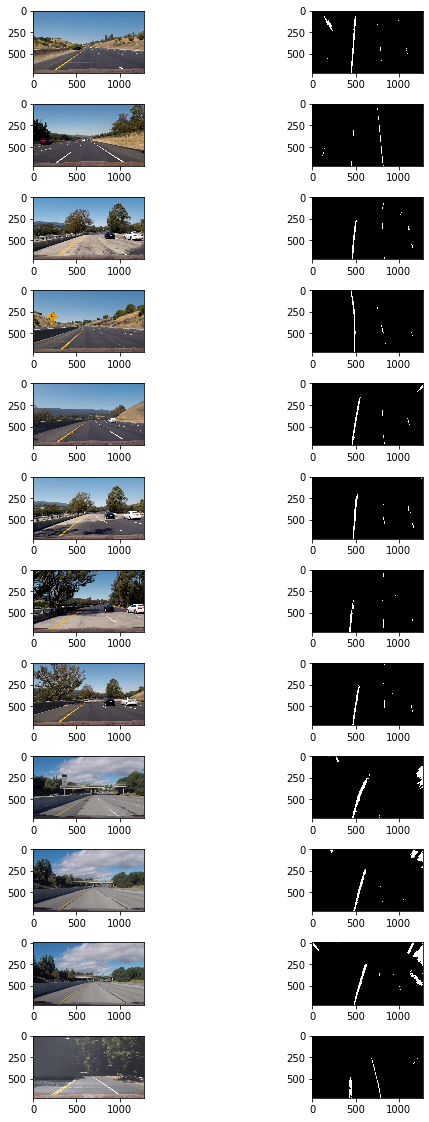

In [28]:
#Creating a pipeline for all the images in test_image folder and saving\
#it to output_image folder

# Make a list of example images
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin, Minv = pipeline(img)
    
    axs[i].imshow(img)
    axs[i].axis('on')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    
    # we can save an output image to output_image folder
    #cv2.imwrite('output_images/'+str(image)+'.jpg',img_bin)
    
    axs[i].axis('on')
    i += 1
    
    


In [29]:
# Define method to fit polynomial to binary image with lines extracted, using sliding window
def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Finding the peak of the left and right halves of the histogram
    # These peaks will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram 
    #(directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    print('base pts:', leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 15 # try using 10
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows) #you can use any manual input number as well
    #(image shape/ number of windows will give you exact dimension)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100 #can use 80
    # Set minimum number of pixels found to recenter window
    minpix = 50 # can use another number, say 4-
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data
print('Your sliding window is complete')

Your sliding window is complete


In [30]:
# visualize the sliding window on example image
example_img = cv2.imread('./test_images/test4.jpg')
example_img = cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB)
example_img_bin, Minv = pipeline(example_img)
#example_img is coming out of pipeline you developed earlier    
left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(exampleImg_bin)

h = example_img.shape[0]
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
#print('fit x-intercepts:', left_fit_x_int, right_fit_x_int)

rectangles = visualization_data[0]
histogram = visualization_data[1]

# Print histogram from sliding window polyfit for example image

plt.plot(histogram) #This is giving the points of maximum peak


# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((example_img_bin, example_img_bin, example_img_bin))*255)
# Generate x and y values for plotting
ploty = np.linspace(0, example_img_bin.shape[0]-1, example_img_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
# Identify the x and y positions of all nonzero pixels in the image
nonzero = example_img_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

plt.plot(histogram)
plt.xlim(0, 1280)

NameError: name 'exampleImg_bin' is not defined

In [ ]:
# You can plot the histogram here.
#Bazinga! it maches with values you got in the above cell (490,830).
plt.plot(histogram)
plt.xlim(0, 1280)


NEXT STEP IS FINDING FROM PRIORI:
For thi we will be using polyfit to fit the curve from the previous frame
test6, test 4 and test 5 are from same video, ordered chronologically

In [ ]:
# This functions is used to fit polynomial to binary image based upon a previous fit (chronologically speaking);
# Assumption: The fit will not change significantly from one video frame to the next
#argument is image, left fit 
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero() #numpy.nonzero()function is used to Compute the indices of the elements that are non-zero.
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    #Now checking if the new points actually lying in the margin +/- previous polynomial points and saving them in array
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds


In [ ]:
# visualizing the result on example image
example_img2 = cv2.imread('./test_images/test5.jpg')
example_img2 = cv2.cvtColor(example_img2, cv2.COLOR_BGR2RGB)
example_img2_bin, Minv = pipeline(example_img2)   
margin = 80

#polyfit_using_prev_fit function is 4 output
#left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_using_prev_fit(example_img2_bin, left_fit, right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, example_img2_bin.shape[0]-1, example_img2_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((example_img2_bin, example_img2_bin, example_img2_bin))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = example_img2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


NOW WE WILL FIND THE RADIUS OF CURVATURE

In [ ]:
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 
    # meters per pixel in y dimension,
    #lane line is 10 ft = 3.048 meters
    
    xm_per_pix = 3.7/378 
    # meters per pixel in x dimension,
    #lane width is 12 ft = 3.7 meters
    
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # We will be choosing the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist

Now we will calculate the distance from the center and radius of curvature in teh sample image. 
Note tha that if you put like thresholds, this will be like ADAS system 

In [ ]:
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(example_img_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Distance from lane center for example:', d_center, 'm')
print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')


In [ ]:
#Displaying (distance from centre and radius of curvature) data on the image
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

In [ ]:
#Drawing line on the image
#Raw function is given in the project description

def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=10)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=10)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

In [ ]:
#Visualizing drawing lines
example_img_out1 = draw_lane(example_img, example_img_bin, left_fit, right_fit, Minv)
plt.imshow(example_img_out1)

#Visulaizing data display ((distance from centre and radius of curvature))
example_img_out2 = draw_data(example_img_out1, (rad_l+rad_r)/2, d_center)
plt.imshow(example_img_out2)

# We want to store data. The best way to do  this here to create a class and store data in it. 

In [ ]:
#Defining a class that takes in the characteristics of each lines detected. 
#PROJECT DESCRIPTION SAYS THAT YOU NEED TO CREATE AN INSTANCE FOR 
#RIGHT AND FOR LEFT LINE BOTH 
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


In [ ]:
#THIS METHOD WILL BE USE FOR PLOTTING A FIT ON A BINARY IMAGE
#reference: Github {this code is used for diagnostic purpose}
def plot_fit_onto_img(img, fit, plot_color):
    if fit is None:
        return img
    new_img = np.copy(img)
    h = new_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
    cv2.polylines(new_img, np.int32([pts]), isClosed=False, color=plot_color, thickness=8)
    return new_img

# creating a pipeline for images. 
###this pipeline is used for the video processing as well

In [ ]:
def process_image(img):
    new_img = np.copy(img)
    img_bin, Minv = pipeline(new_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    
    diagnostic_output = False
    if diagnostic_output:
        # put together multi-view output
        diag_img = np.zeros((720,1280,3), dtype=np.uint8)
        
        # original output (top left)
        diag_img[0:360,0:640,:] = cv2.resize(img_out,(640,360))
        
        # binary overhead view (top right)
        img_bin = np.dstack((img_bin*255, img_bin*255, img_bin*255))
        resized_img_bin = cv2.resize(img_bin,(640,360))
        diag_img[0:360,640:1280, :] = resized_img_bin
        
        # overhead with all fits added (bottom right)
        img_bin_fit = np.copy(img_bin)
        for i, fit in enumerate(l_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (20*i+100,0,20*i+100))
        for i, fit in enumerate(r_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (0,20*i+100,20*i+100))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, l_line.best_fit, (255,255,0))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, r_line.best_fit, (255,255,0))
        diag_img[360:720,640:1280,:] = cv2.resize(img_bin_fit,(640,360))
        
        # diagnostic data (bottom left)
        color_ok = (200,255,155)
        color_bad = (255,155,155)
        font = cv2.FONT_HERSHEY_DUPLEX
        if l_fit is not None:
            text = 'This fit L: ' + ' {:0.6f}'.format(l_fit[0]) + \
                                    ' {:0.6f}'.format(l_fit[1]) + \
                                    ' {:0.6f}'.format(l_fit[2])
        else:
            text = 'This fit L: None'
        cv2.putText(diag_img, text, (40,380), font, .5, color_ok, 1, cv2.LINE_AA)
        if r_fit is not None:
            text = 'This fit R: ' + ' {:0.6f}'.format(r_fit[0]) + \
                                    ' {:0.6f}'.format(r_fit[1]) + \
                                    ' {:0.6f}'.format(r_fit[2])
        else:
            text = 'This fit R: None'
        cv2.putText(diag_img, text, (40,400), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit L: ' + ' {:0.6f}'.format(l_line.best_fit[0]) + \
                                ' {:0.6f}'.format(l_line.best_fit[1]) + \
                                ' {:0.6f}'.format(l_line.best_fit[2])
        cv2.putText(diag_img, text, (40,440), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit R: ' + ' {:0.6f}'.format(r_line.best_fit[0]) + \
                                ' {:0.6f}'.format(r_line.best_fit[1]) + \
                                ' {:0.6f}'.format(r_line.best_fit[2])
        cv2.putText(diag_img, text, (40,460), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Diffs L: ' + ' {:0.6f}'.format(l_line.diffs[0]) + \
                             ' {:0.6f}'.format(l_line.diffs[1]) + \
                             ' {:0.6f}'.format(l_line.diffs[2])
        if l_line.diffs[0] > 0.001 or \
           l_line.diffs[1] > 1.0 or \
           l_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,500), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Diffs R: ' + ' {:0.6f}'.format(r_line.diffs[0]) + \
                             ' {:0.6f}'.format(r_line.diffs[1]) + \
                             ' {:0.6f}'.format(r_line.diffs[2])
        if r_line.diffs[0] > 0.001 or \
           r_line.diffs[1] > 1.0 or \
           r_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,520), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Good fit count L:' + str(len(l_line.current_fit))
        cv2.putText(diag_img, text, (40,560), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Good fit count R:' + str(len(r_line.current_fit))
        cv2.putText(diag_img, text, (40,580), font, .5, color_ok, 1, cv2.LINE_AA)
        
        img_out = diag_img
    return img_out

# Project Video

In [ ]:
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output1))

# Challenge Video

In [ ]:
l_line = Line()
r_line = Line()
video_output2 = 'challenge_video_output.mp4'
video_input2 = VideoFileClip('challenge_video.mp4')#.subclip(10,12)
#video_input2.save_frame("challenge01.jpeg", t=0.25) # saves the frame at time = 0.25s
processed_video = video_input2.fl_image(process_image)
%time processed_video.write_videofile(video_output2, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output2))

# Harder Challenge Video

In [ ]:
l_line = Line()
r_line = Line()
video_output3 = 'harder_challenge_video_output.mp4'
video_input3 = VideoFileClip('harder_challenge_video.mp4')#.subclip(0,3)
#video_input3.save_frame("hard_challenge01.jpeg") # saves the first frame
processed_video = video_input3.fl_image(process_image)
%time processed_video.write_videofile(video_output3, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output3))